#DONE BY
##Ateeb Ahmad
##Saqib Nawab

#Importing Necessary Libraries



In [173]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import json
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

#Importing Prompt Dataset

In [174]:
!gdown https://drive.google.com/file/d/1nDPgXzAgu3iOR7i4yF49xlCMZ3irgkpu/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1nDPgXzAgu3iOR7i4yF49xlCMZ3irgkpu
To: /content/prompts.json
100% 17.9k/17.9k [00:00<00:00, 51.4MB/s]


#Preprocessing the Data

##Loading the JSON File

In [175]:
with open("/content/prompts.json") as f:
  data = json.load(f)

##Gettings Tags, Prompts, and Responses

In [176]:
tags = []
prompts = []
responses = []

for i in data['intents']:
  tags.append(i['tag'])

  for j in i['questions']:

    # Making the prompts lowercased
    prompt = j.lower()

    # Removing punctuations like ? and .
    prompt = prompt.strip("?.")

    prompts.append((prompt, i['tag']))

In [178]:
labelsToid = {label:id for id,label in enumerate(tags)}
idTolabels = {id:label for id,label in enumerate(tags)}

In [179]:
idTolabels

{0: 'greeting',
 1: 'creator',
 2: 'name',
 3: 'general',
 4: 'location_recommendation',
 5: 'hotel_recommendation',
 6: 'safety_and_amenities',
 7: 'rent_pricing',
 8: 'hotel_pricing',
 9: 'property_inspection',
 10: 'legal_documentation',
 11: 'goodbye'}

In [180]:
labelsToid

{'greeting': 0,
 'creator': 1,
 'name': 2,
 'general': 3,
 'location_recommendation': 4,
 'hotel_recommendation': 5,
 'safety_and_amenities': 6,
 'rent_pricing': 7,
 'hotel_pricing': 8,
 'property_inspection': 9,
 'legal_documentation': 10,
 'goodbye': 11}

#Using PreTrained BERT Model & Tokenizer

In [181]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=len(tags)
                                                      )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [182]:
model = model.to(device)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

#Creating Dataset

In [183]:
class Dataset(Dataset):
  def __init__(self, prompts, labels):
    self.prompt = prompts
    self.label = labels

  def __len__(self):
    return len(self.prompt)

  def __getitem__(self, index):

    # Getting prompts
    prompt = self.prompt[index]

    # Extracting label id from prompt
    label_id = self.label[prompt[1]]

    # Converting to tensor
    label_id = torch.tensor(label_id)

    # Returning the prompt and it's respective label id
    return prompt[0], label_id

In [184]:
dataset = Dataset(prompts, labelsToid)

#Splitting the Dataset into Train & Test

In [185]:
trainset, testset = train_test_split(dataset, test_size=0.25, random_state=40)

##Creating DataLoaders

In [186]:
batchSize = 32

trainLoader = DataLoader(
    trainset,
    batch_size = batchSize,
    shuffle = True,
)

valLoader = DataLoader(
    testset,
    batch_size = batchSize,
    shuffle = False
)

##Defining Optimizer

In [187]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

##Defining Training & Testing Function

In [188]:
def train_or_val(model, optimizer, dataloader, train):

  if train:
    model.train()
  else:
    model.eval()

  running_loss = 0
  correct = 0
  pre, rec, f1 = 0,0,0
  all_labels = []
  all_preds = []

  for prompt, labels in dataloader:

    # Passing Inputs to Tokenizer
    input = tokenizer(prompt, return_tensors='pt', truncation=True, padding=True)

    # Passing them on CUDA or CPU depending on the availability
    input = input.to(device)
    labels = labels.to(device)

    # Forward Pass
    yhat = model(**input, labels = labels)

    # Getting Predictions
    pred = yhat['logits'].argmax(1)

    # Computing loss
    loss = yhat.loss
    running_loss += loss.item()

    # Backpropogation
    if train:
      optimizer.zero_grad() # Making gradient equal to zero to avoid accumulation
      loss.backward() # Calculating Gradients
      optimizer.step() # Updating weights and biases

    else:
      # Computing Accuracy
      correct += (pred == labels).sum()

      # Computing Precision, Recall, and F1 score
      p, r, f, _ = precision_recall_fscore_support(labels.cpu().numpy(), pred.cpu().numpy(), average='macro', zero_division=1)
      pre += p
      rec += r
      f1 += f

      # Append true labels and predictions
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(pred.cpu().numpy())

  # Calculating Loss
  loss = running_loss/len(dataloader)

  if train:
    return loss

  else:
    # Calculating Accuracy
    accuracy = correct/len(dataloader.dataset) * 100

    # Calculating Precision, Recall, F1 Score
    precision = pre/len(dataloader) * 100
    recall = rec/len(dataloader) * 100
    f1 = f1/len(dataloader) * 100

    return loss, accuracy, precision, recall, f1, all_labels, all_preds

##Mounting Google Drive for Saving and Loading Model

In [189]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Starting Training

In [190]:
Epochs = 50
train_losses, val_losses = [], []

for i in range(0, Epochs):

  t_loss = train_or_val(model, optimizer, trainLoader, True)
  train_losses.append(t_loss)

  v_loss, v_acc, p, r, f, all_labels, all_preds = train_or_val(model, optimizer, valLoader, False)

  print(f"Epoch {i + 1}: Train: Train Loss: {t_loss:>0.3f}")
  print(f"\t Val: Val Loss: {v_loss:>0.3f} Val Accuracy: {v_acc:>0.1f}% Precision: {p:>0.1f}% Recall: {r:>0.1f}% F1 Score: {f:>0.1f}%")

  val_losses.append(v_loss)

Epoch 1: Train: Train Loss: 2.511
	 Val: Val Loss: 2.509 Val Accuracy: 6.1% Precision: 54.8% Recall: 31.8% F1 Score: 2.7%
Epoch 2: Train: Train Loss: 2.448
	 Val: Val Loss: 2.383 Val Accuracy: 9.1% Precision: 57.3% Recall: 30.3% F1 Score: 2.2%
Epoch 3: Train: Train Loss: 2.386
	 Val: Val Loss: 2.345 Val Accuracy: 21.2% Precision: 83.8% Recall: 61.1% F1 Score: 54.2%
Epoch 4: Train: Train Loss: 2.294
	 Val: Val Loss: 2.309 Val Accuracy: 21.2% Precision: 59.4% Recall: 42.4% F1 Score: 11.0%
Epoch 5: Train: Train Loss: 2.154
	 Val: Val Loss: 2.312 Val Accuracy: 27.3% Precision: 59.9% Recall: 42.4% F1 Score: 10.4%
Epoch 6: Train: Train Loss: 2.039
	 Val: Val Loss: 2.255 Val Accuracy: 33.3% Precision: 60.2% Recall: 43.8% F1 Score: 11.3%
Epoch 7: Train: Train Loss: 2.028
	 Val: Val Loss: 2.180 Val Accuracy: 42.4% Precision: 62.4% Recall: 50.0% F1 Score: 14.2%
Epoch 8: Train: Train Loss: 1.833
	 Val: Val Loss: 2.089 Val Accuracy: 45.5% Precision: 61.1% Recall: 50.8% F1 Score: 16.1%
Epoch 9: Tra

#Visualizing Graphs

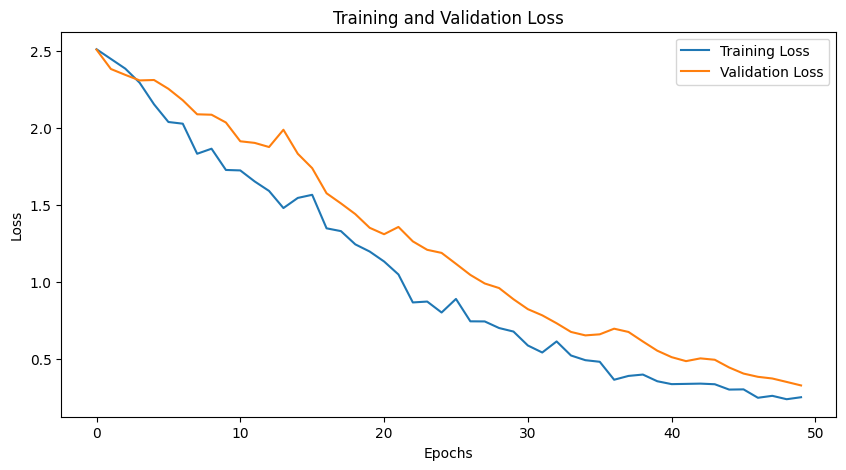

In [196]:
# Training Loss Vs Validaiton Loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Visualizing Confusion Matrix

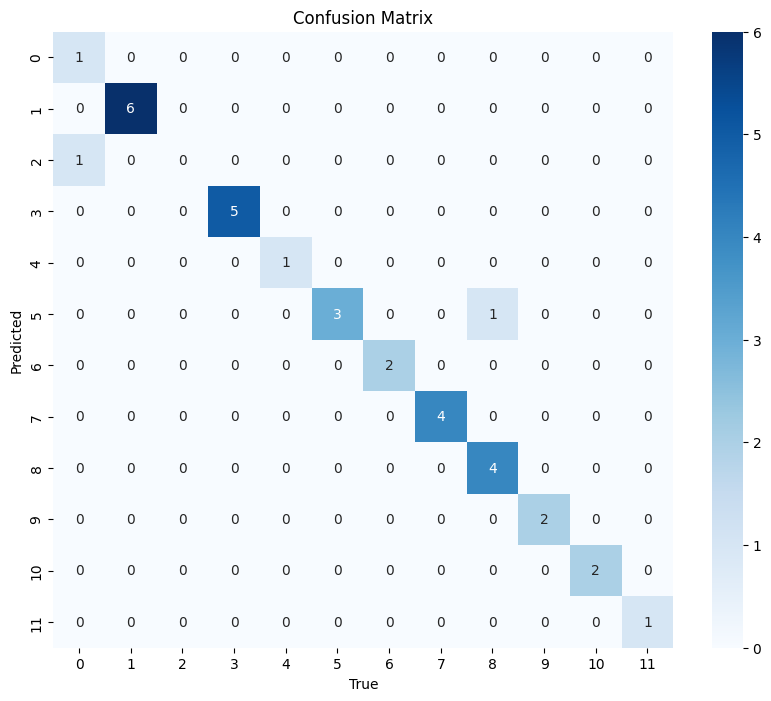

In [191]:
# Create Confusion Matrix
cm = confusion_matrix(all_preds, all_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

#Saving the Model

In [192]:
save_path = '/content/drive/MyDrive/FYP/chatbot.pth'

torch.save(model.state_dict(), save_path)

#Chatting with the Model

In [193]:
def chatbot(prompt):

  # Passing Inputs to Tokenizer
  input = tokenizer(prompt, return_tensors='pt', truncation=True, padding=True)

  # Passing them on CUDA or CPU depending on the availability
  input = input.to(device)

  # Forward Pass
  yhat = model(**input)

  # Getting label id
  pred = yhat['logits'].argmax(1)

  # Getting label
  label = idTolabels[pred.item()]

  # Getting responses
  response = random.choice(data['intents'][pred.item()]['responses'])

  return label, response

In [194]:
print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..\n")

while(1):

  text = input("User: ").strip("?.").lower()
  label, response = chatbot(text)
  print("Chatbot:", response,"\n")

  # If intent of the user is detected to be leaving than end the chat
  if label == "goodbye":
    break

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..

User: Hey
Chatbot: Good to see you again! 

User: Who are you?
Chatbot: I am your Property Agent 

User: You were created by whom?
Chatbot: Made By: Team RENTA 

User: I am looking for rental houses in Islamabad?
Chatbot: Common rental properties in Islamabad include apartments, houses, and commercial spaces. Apartments range from one to three bedrooms, while houses can vary in size and features. Commercial spaces are available in business districts. 

User: Which sectors are good for rental?
Chatbot: Commonly preferred sectors for renting properties in Islamabad are F-6, F-7, G-10, and G-11. These areas offer a mix of amenities and a comfortable living environment. 

User: tell me about rent prices in islamabad?
Chatbot: Insights into the rental rates for houses in Islamabad show a range of PKR 40,000 to PKR 100,000 or more per month, with variations across sec